In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from collections import defaultdict

import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

In [3]:
with open('../data/01-House-Price/processed_data.pkl','rb') as file:
    train,y,test,FEATURES = pickle.load(file)

## **Building ML model**

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1017, 437)
X_test : (437, 437)
y_train : (1017,)
y_test : (437,)


# **Feature Standardizing**
- Perform standardization on all features except those one hot encoded.

In [5]:
FEATURES.keys()

dict_keys(['cat', 'num', 'aug_num', 'eng_num', 'ord_num', 'onehot_cat', 'interactions', 'interactions_num'])

In [6]:
feat_to_norm = FEATURES['num'] + FEATURES['aug_num'] + FEATURES['eng_num'] + FEATURES['ord_num'] + FEATURES['interactions_num']
print('Total %i features to normalize' %(len(feat_to_norm)))

Total 217 features to normalize


In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train[feat_to_norm])

X_num_train_norm = pd.DataFrame(ss.transform(X_train[feat_to_norm]),columns=feat_to_norm,index=X_train.index)
X_cat_train = X_train[[col for col in X_train.columns if col not in feat_to_norm]]
X_train_preproc = pd.concat([X_num_train_norm,X_cat_train],axis=1)

X_num_test_norm = pd.DataFrame(ss.transform(X_test[feat_to_norm]),columns=feat_to_norm,index=X_test.index)
X_cat_test = X_test[[col for col in X_test.columns if col not in feat_to_norm]]
X_test_preproc = pd.concat([X_num_test_norm,X_cat_test],axis=1)

print("X_train_preproc : " + str(X_train_preproc.shape))
print("X_test_preproc : " + str(X_test_preproc.shape))

X_train_preproc : (1017, 437)
X_test_preproc : (437, 437)


In [8]:
from collections import namedtuple

models = namedtuple('models',['name','params',
                              'cv5_mean_train_rmse','cv5_std_train_rmse',
                              'cv5_mean_test_rmse','cv5_std_test_rmse'])
model_list = []

## **Linear Regression**

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score

In [10]:
def cv_rmse(mod,X,y,cv=5):
    scores = cross_val_score(mod,X,y,scoring="neg_mean_squared_error",cv=cv)
    return np.sqrt(-scores)

In [11]:
lr = LinearRegression()
lr.fit(X_train_preproc,y_train)


y_train_pred = lr.predict(X_train_preproc)
y_test_pred = lr.predict(X_test_preproc)

print('Train R-sq:',r2_score(y_train,y_train_pred))
print('Test R-sq:',r2_score(y_test,y_test_pred))

Train R-sq: 0.963162885762564
Test R-sq: 0.5559804776700874


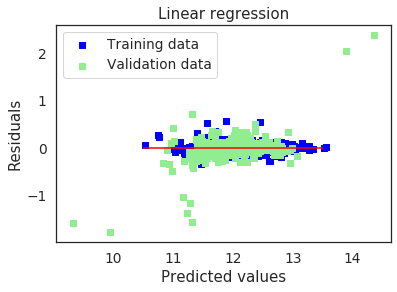

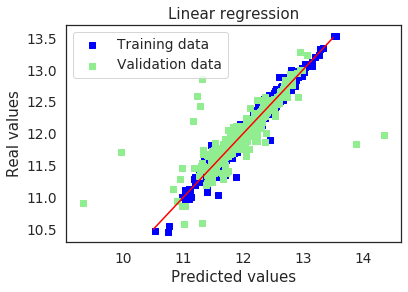

In [12]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

In [13]:
cv5_train_rmse =  cv_rmse(lr, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(lr, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='LR',params=lr.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.88424246 0.21429221 3.33544394 4.79528007 0.20554063]
---------------------------------------------------------------------------
cv5 test rmse: [18.07818707 56.25612785 30.25145166 57.269396    3.02570743]


## **Linear Regression with Ridge regularization (L2 penatly)**

In [14]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train_preproc, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 30.0


In [15]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9048716584871587
MSE: 0.014326940034714304
RMSE: 0.11969519637276303
--------------------------------------------------
R-sq orig price: 0.905364908377559
MSE orig price: 503867200.8891325
RMSE orig price: 22446.986454513943


In [16]:
ridge = Ridge(alpha=30)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9103954055162604
MSE: 0.013495028207026362
RMSE: 0.1161681032255686
--------------------------------------------------
R-sq orig price: 0.9092341685719704
MSE orig price: 483266034.1311614
RMSE orig price: 21983.312628700012


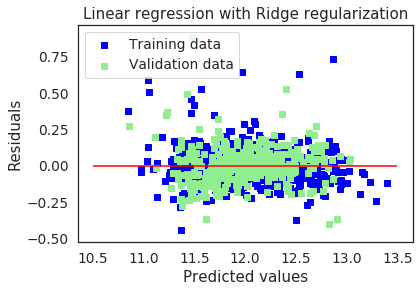

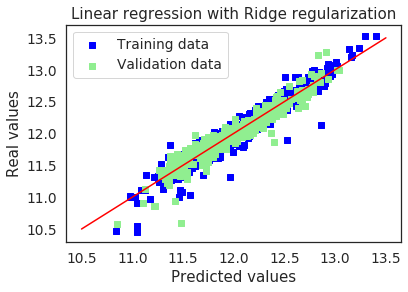

Ridge picked 425 features and eliminated the other 12 features


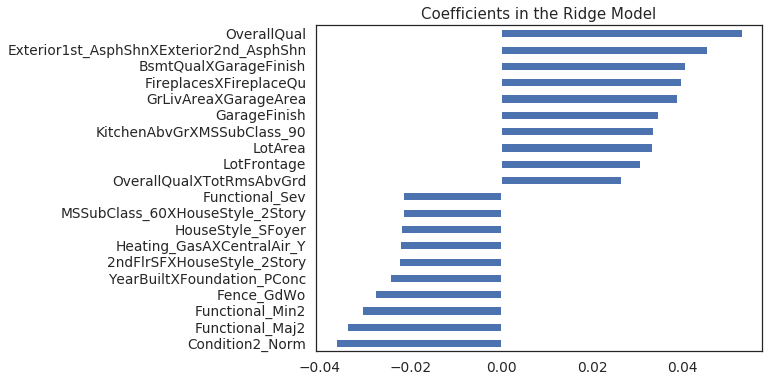

In [17]:
y_train_rdg = ridge.predict(X_train_preproc)
y_test_rdg = ridge.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Ridge Model");

In [18]:
cv5_train_rmse =  cv_rmse(ridge, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(ridge, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='ridge',params=ridge.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.13964947 0.15186896 0.11484041 0.12236541 0.10467946]
---------------------------------------------------------------------------
cv5 test rmse: [0.1214073  0.12550299 0.14706597 0.10652404 0.10124694]


## **Linear Regression with Lasso regularization (L1 penalty)**

In [19]:
from sklearn.linear_model import LassoCV, Lasso

In [20]:
lasso = Lasso(alpha=1)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: -0.010079098464402358
MSE: 0.15212440839267974
RMSE: 0.39003129155579264
--------------------------------------------------
R-sq orig price: -0.007748113294549386
MSE orig price: 5365570131.984954
RMSE orig price: 73250.0520954419


In [21]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train_preproc, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0003


In [22]:
lasso = Lasso(alpha=0.0003)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))


y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: 0.9030445387978207
MSE: 0.014602116010759874
RMSE: 0.12083921553353395
--------------------------------------------------
R-sq orig price: 0.8969636552917514
MSE orig price: 548598133.1863786
RMSE orig price: 23422.17182898244


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7012142126614496, tolerance: 0.01648745737340829
  positive)


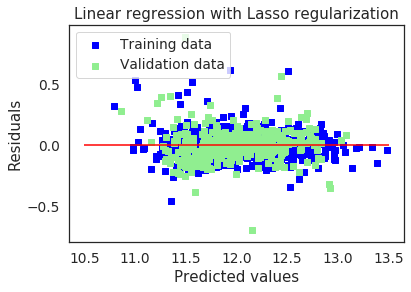

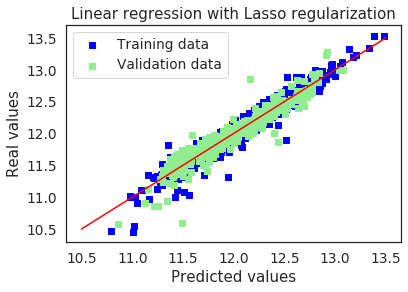

Lasso picked 166 features and eliminated the other 271 features


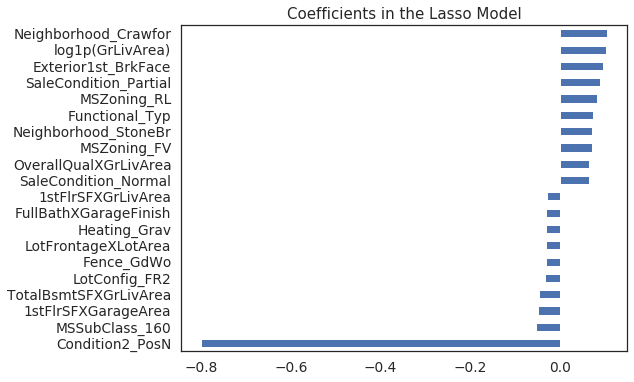

In [23]:
y_train_las = lasso.predict(X_train_preproc)
y_test_las = lasso.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train_preproc.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Lasso Model");

In [24]:
cv5_train_rmse =  cv_rmse(lasso, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(lasso, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='lasso',params=lasso.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.392107306472111, tolerance: 0.012625547164138353
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6100559940255783, tolerance: 0.013706716282636094
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6590687977097813, tolerance: 0.0132498040571775
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to

cv5 train rmse: [0.14187845 0.14869505 0.11541697 0.11842423 0.10342945]
---------------------------------------------------------------------------
cv5 test rmse: [0.12658122 0.13590155 0.15166399 0.10744668 0.10038656]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2218623974713303, tolerance: 0.005357294318284767
  positive)


## **Linear Regression with ElasticNet Regularization (L1 and L2 penalty)**

In [25]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [26]:
enet = ElasticNet(alpha=1,l1_ratio=0.5)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: -0.010079098464402358
MSE: 0.15212440839267974
RMSE: 0.39003129155579264
--------------------------------------------------
R-sq: -0.007748113294549386
MSE: 5365570131.984954
RMSE: 73250.0520954419


In [27]:
enet = ElasticNetCV(l1_ratio=np.arange(0,1.1,0.1),
             alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
             cv=5,
             max_iter=50000,
             n_jobs=16,
             random_state=42)
enet.fit(X_train_preproc, y_train)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent

ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03,
                     0.06, 0.1, 0.3, 0.6, 1],
             copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
             max_iter=50000, n_alphas=100, n_jobs=16, normalize=False,
             positive=False, precompute='auto', random_state=42,
             selection='cyclic', tol=0.0001, verbose=0)

In [31]:
print('Best alpha: ',enet.alpha_)
print('Best l1_ratio: ',enet.l1_ratio_)

Best alpha:  0.0003
Best l1_ratio:  1.0


In [64]:
param_grid_enet = dict(l1_ratio=np.arange(0,1.1,0.1),
                       alpha=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1])

enet_cv = GridSearchCV(ElasticNet(),param_grid=param_grid_enet,n_jobs=-1,cv=5)
enet_cv.fit(X_train_preproc,y_train)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7012142126614496, tolerance: 0.01648745737340829
  positive)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006,
                                   0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [65]:
enet_cv.best_estimator_

ElasticNet(alpha=0.0003, copy_X=True, fit_intercept=True, l1_ratio=1.0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
enet = ElasticNet(l1_ratio=1,alpha=0.0003) 
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.9030445387978207
MSE: 0.014602116010759874
RMSE: 0.12083921553353395
--------------------------------------------------
R-sq: 0.8969636552917514
MSE: 548598133.1863786
RMSE: 23422.17182898244


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7012142126614496, tolerance: 0.01648745737340829
  positive)


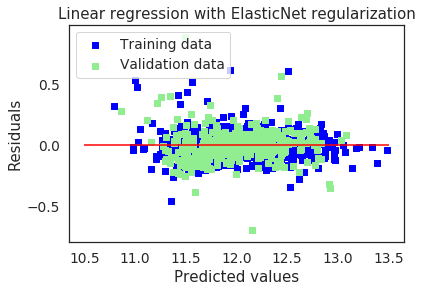

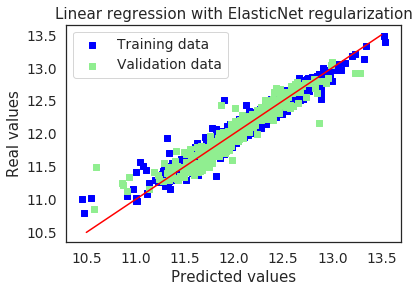

ElasticNet picked 166 features and eliminated the other 271 features


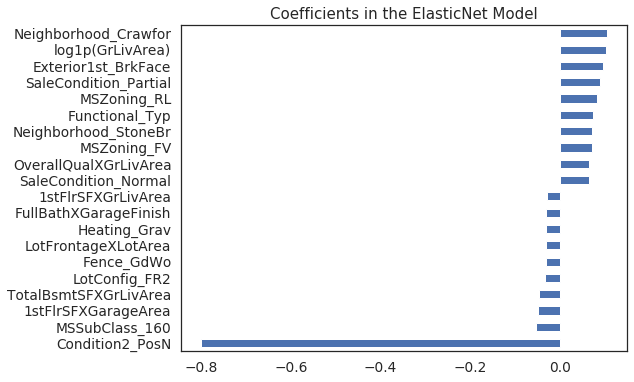

In [33]:
y_train_ela = enet.predict(X_train_preproc)
y_test_ela = enet.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(enet.coef_, index = X_train_preproc.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the ElasticNet Model");

In [34]:
cv5_train_rmse =  cv_rmse(enet, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(enet, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='enet',params=enet.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.392107306472111, tolerance: 0.012625547164138353
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6100559940255783, tolerance: 0.013706716282636094
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6590687977097813, tolerance: 0.0132498040571775
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to

cv5 train rmse: [0.14187845 0.14869505 0.11541697 0.11842423 0.10342945]
---------------------------------------------------------------------------
cv5 test rmse: [0.12658122 0.13590155 0.15166399 0.10744668 0.10038656]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2802565012911684, tolerance: 0.004912019618576038
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2218623974713303, tolerance: 0.005357294318284767
  positive)


## **Support Vector Machine Regression**

In [35]:
from sklearn.svm import SVR

In [36]:
svm = SVR(C=0.1, cache_size=200, coef0=1, degree=3, epsilon=0.1,
          gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
svm.fit(X_train_preproc,y_train)
y_pred = svm.predict(X_test_preproc)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8972240662238975
MSE: 0.01547871661384133
RMSE: 0.12441349048170512
--------------------------------------------------
R-sq: 0.9065123386654798
MSE: 497757918.6189079
RMSE: 22310.48898206644


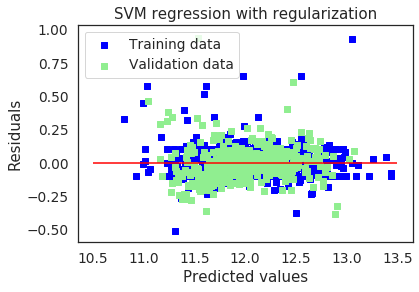

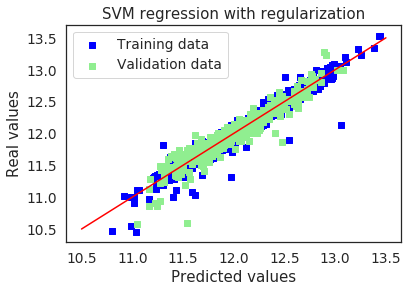

SVR picked up 407 features and eliminated 30 features


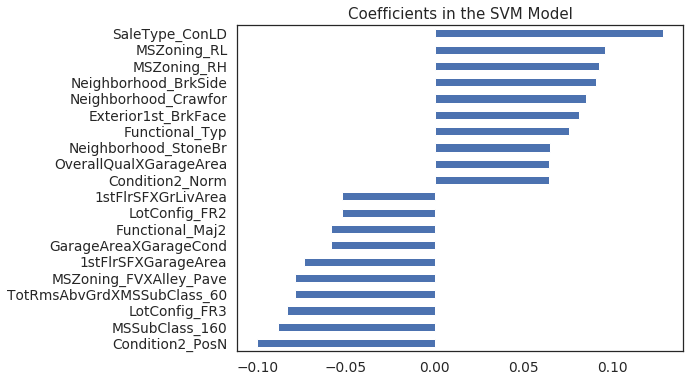

In [37]:
y_train_svm = svm.predict(X_train_preproc)
y_test_svm = svm.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_svm, y_train_svm - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test_svm - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_svm, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(np.squeeze(svm.coef_) , index = X_train_preproc.columns)
print("SVR picked up " + str(sum(coefs != 0)) + " features and eliminated " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the SVM Model");

In [38]:
cv5_train_rmse =  cv_rmse(svm, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(svm, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='svm',params=svm.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15219448 0.15795169 0.1286967  0.13171517 0.13436592]
---------------------------------------------------------------------------
cv5 test rmse: [0.13712425 0.14300951 0.14986881 0.12475993 0.11831553]


## **Random Forest**

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8919426914221277
MSE: 0.01627412562531447
RMSE: 0.12757008123111968
--------------------------------------------------
R-sq: 0.9148230546936682
MSE: 453509034.29157686
RMSE: 21295.751554983377


In [41]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

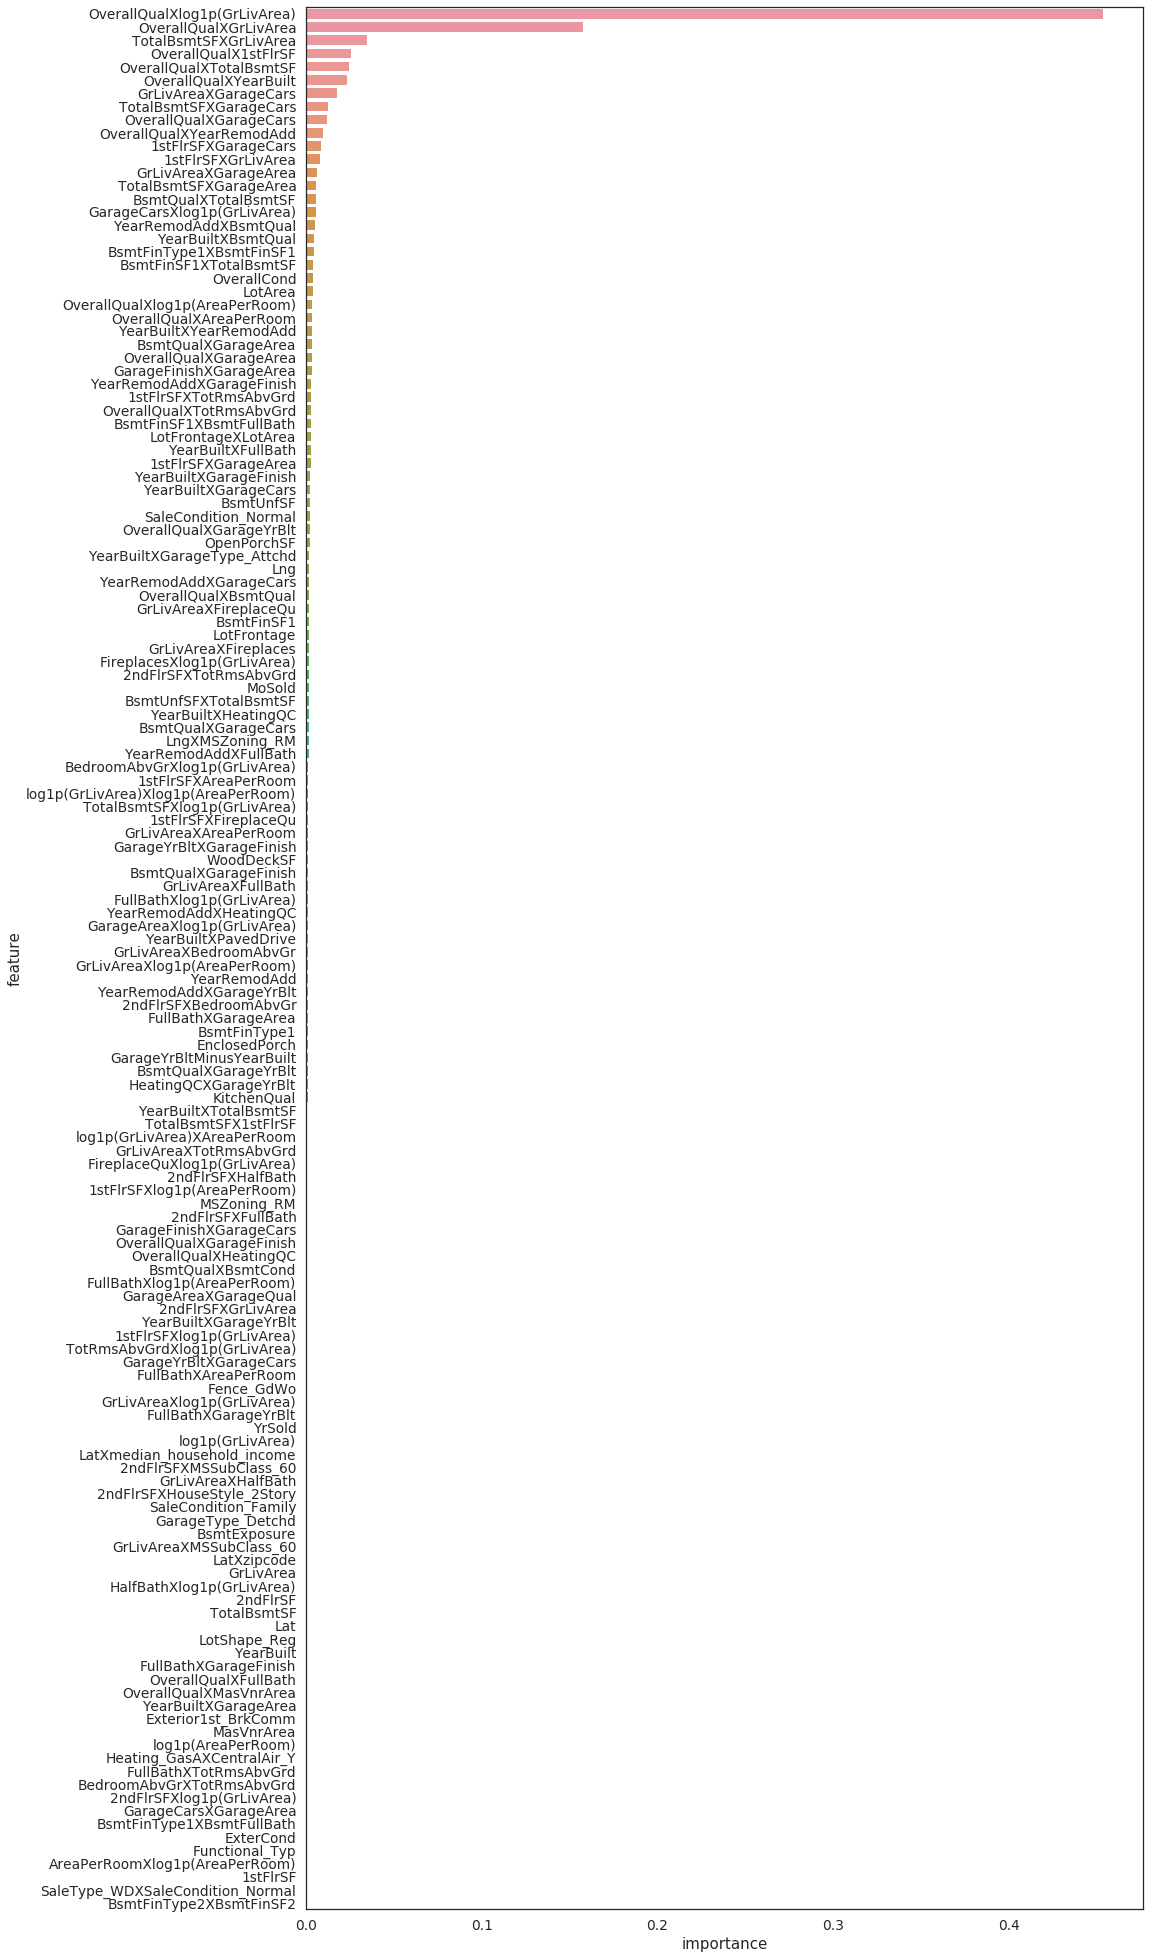

In [42]:
plt.figure(figsize=(15,35))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [43]:
rf = RandomForestRegressor()
param_dist = dict(n_estimators=[500,600,700,800,900])

rf_cv = GridSearchCV(RandomForestRegressor(),param_grid=param_dist,n_jobs=5,cv=5)
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=5,
             param_grid={'n_estimators': [500, 600, 700, 80

In [44]:
rf_cv.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [45]:
rf = rf_cv.best_estimator_

rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8901229663481934
MSE: 0.016548187924722915
RMSE: 0.12863976027932778
--------------------------------------------------
R-sq: 0.9128735766801835
MSE: 463888672.67950577
RMSE: 21538.074952964245


In [46]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

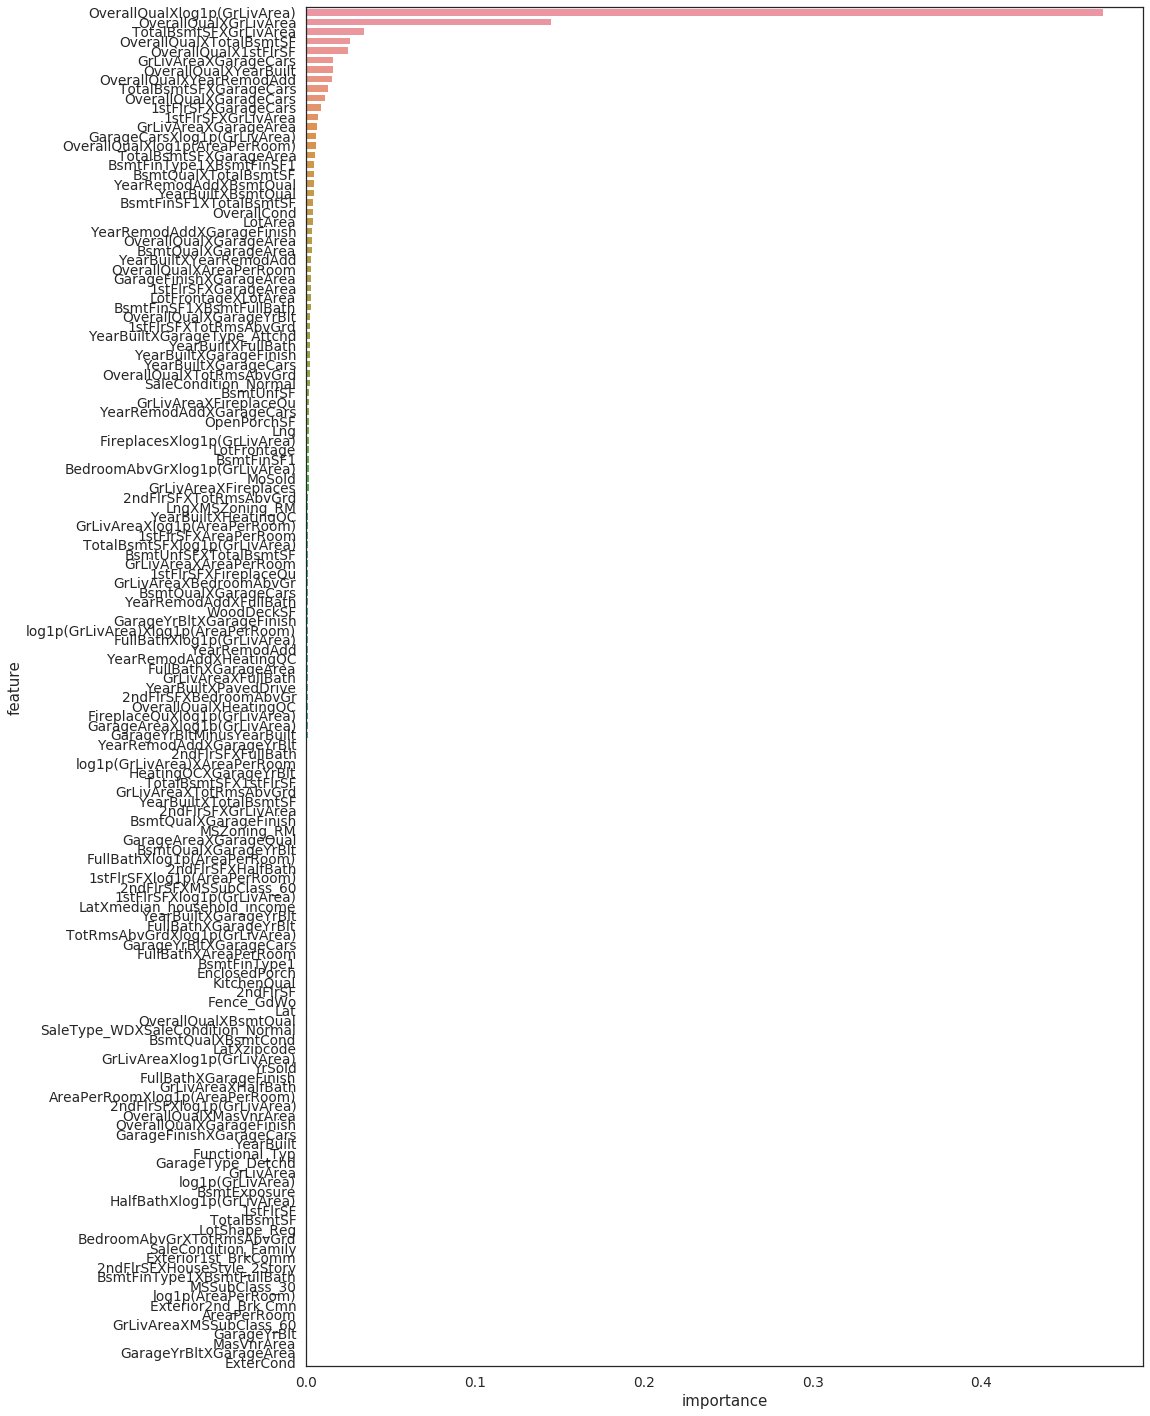

In [47]:
plt.figure(figsize=(15,25))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [48]:
cv5_train_rmse =  cv_rmse(rf, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(rf, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='rf',params=rf.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.16009629 0.15151001 0.14717223 0.15121478 0.13077029]
---------------------------------------------------------------------------
cv5 test rmse: [0.12929842 0.15770529 0.17439113 0.09405006 0.12496951]


## **Adaptive Boost (AdaBoost)**

In [49]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [50]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                       n_estimators=200,learning_rate=0.5,random_state=42)

ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8936074650400747
MSE: 0.01602340001172347
RMSE: 0.1265835692802327
--------------------------------------------------
R-sq: 0.9174745807491678
MSE: 439391469.77333903
RMSE: 20961.66667451181


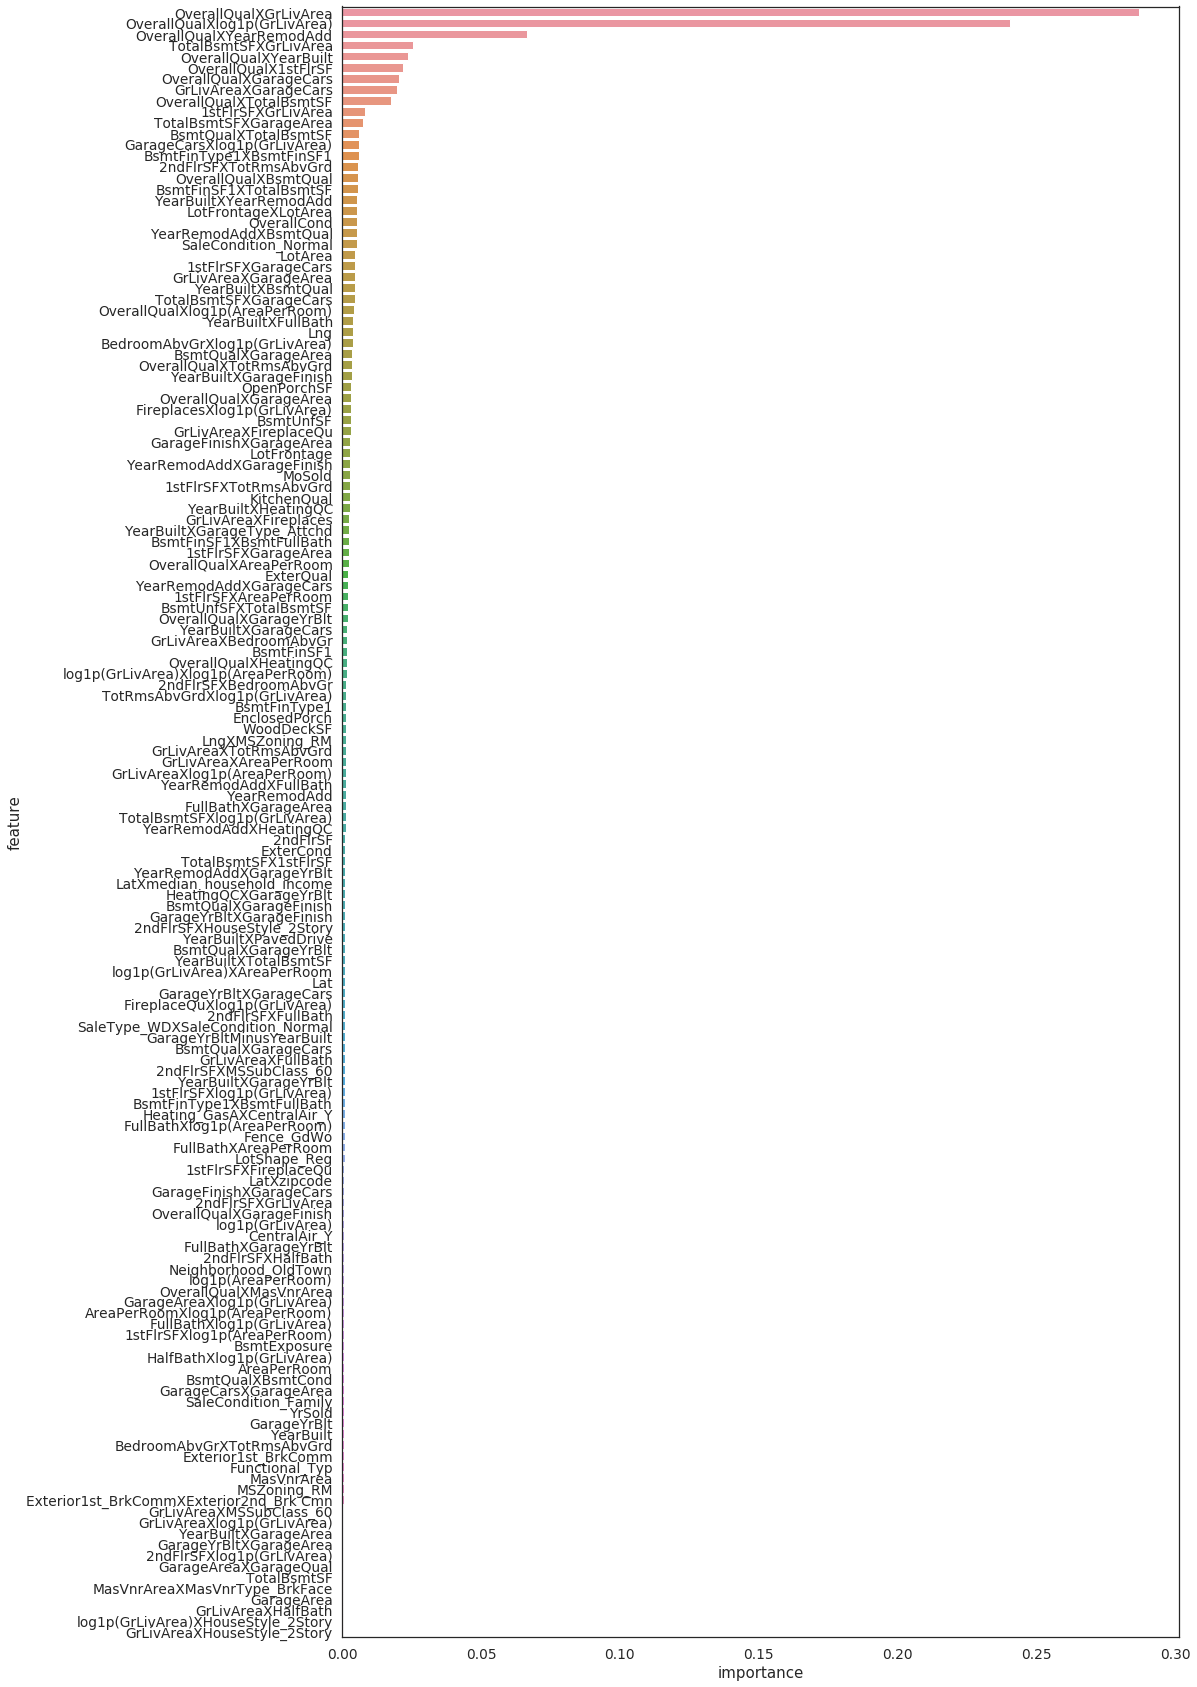

In [47]:
feature_importance = pd.DataFrame(np.round(ada.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(15,30))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [51]:
with open('ada_mod.pkl','rb') as mod_file:
    ada_cv = pickle.load(mod_file)
    
ada_cv.best_estimator_

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator AdaBoostRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=25,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=12,
                                                       min_samples_split=15,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.5, loss='square', n_estimators=400,
                  rand

In [52]:
ada = ada_cv.best_estimator_
ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8939872717885023
MSE: 0.015966198672743244
RMSE: 0.12635742428818042
--------------------------------------------------
R-sq: 0.9153627807252409
MSE: 450635361.95594376
RMSE: 21228.17377816433


In [51]:
cv5_train_rmse =  cv_rmse(ada, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(ada, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='ada',params=ada.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.16197243 0.15913928 0.14400011 0.1489183  0.13712273]
---------------------------------------------------------------------------
cv5 test rmse: [0.13137407 0.15870533 0.17339897 0.09486103 0.13160348]


## **Gradient Boost**

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

In [53]:
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train,y_train)
y_pred = gbrt.predict(X_test)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9054511734306278
MSE: 0.014239661357169184
RMSE: 0.11933005219628953
--------------------------------------------------
R-sq orig price: 0.9083601269925493
MSE orig price: 487919708.328896
RMSE orig price: 22088.904643030535


In [54]:
cv5_train_rmse =  cv_rmse(gbrt, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(gbrt, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='gbrt',params=gbrt.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15338351 0.1459627  0.13852531 0.14066176 0.12100834]
---------------------------------------------------------------------------
cv5 test rmse: [0.13160518 0.1534553  0.16694699 0.09908568 0.11800746]


In [55]:
mod_table = pd.DataFrame()
for model in model_list:
    tmp_df = pd.DataFrame([model.name,
                           model.cv5_mean_train_rmse,
                           model.cv5_std_train_rmse,
                           model.cv5_mean_test_rmse,
                           model.cv5_std_test_rmse],
                          index=['model',
                                   'train_mean_rmse',
                                   'train_std_rmse',
                                   'test_mean_rmse',
                                   'test_std_rmse']).T
    
    mod_table = pd.concat([mod_table,tmp_df],axis=0)
    
mod_table.reset_index(drop=True,inplace=True)

In [56]:
for col in mod_table.columns:
    if col != 'model':
        mod_table[col]= mod_table[col].astype(float)

In [57]:
mod_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
model              8 non-null object
train_mean_rmse    8 non-null float64
train_std_rmse     8 non-null float64
test_mean_rmse     8 non-null float64
test_std_rmse      8 non-null float64
dtypes: float64(4), object(1)
memory usage: 400.0+ bytes


Text(0.5, 1.0, 'Train vs. Test RMSE')

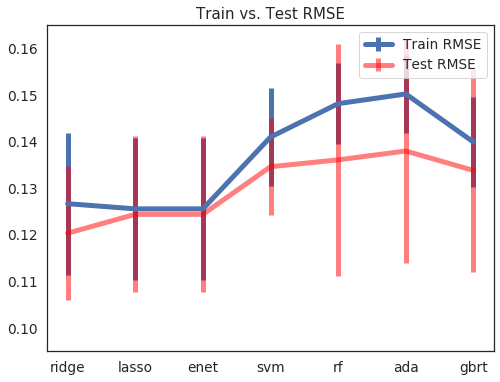

In [58]:
train_errorbar_width_array = (mod_table.loc[1:,'train_std_rmse']/np.sqrt(5))*2

plt.figure(figsize =(8,6))
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'train_mean_rmse'],
             yerr=train_errorbar_width_array,
             label='Train RMSE',
             linewidth=5)

test_errorbar_width_array = (mod_table.loc[1:,'test_std_rmse']/np.sqrt(5))*2
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'test_mean_rmse'],
             yerr=test_errorbar_width_array,
             label='Test RMSE',
             linewidth=5,
             color='red',
             alpha =0.5)
plt.legend()
plt.ylim(0.095,0.165)
plt.title('Train vs. Test RMSE')

In [59]:
mod_table.sort_values(by=['test_mean_rmse','test_std_rmse'],ascending=[True,True])

,model,train_mean_rmse,train_std_rmse,test_mean_rmse,test_std_rmse
1,ridge,0.126681,0.017003,0.120349,0.016109
2,lasso,0.125569,0.017000,0.124396,0.018678
3,enet,0.125569,0.017000,0.124396,0.018678
7,gbrt,0.139908,0.010751,0.133820,0.024267
4,svm,0.140985,0.011784,0.134616,0.011595
5,rf,0.148153,0.009658,0.136083,0.027826
6,ada,0.150231,0.009269,0.137989,0.026935
0,LR,1.886960,1.854015,32.976174,21.253336


In [60]:
enet

ElasticNet(alpha=0.0003, copy_X=True, fit_intercept=True, l1_ratio=1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [61]:
ridge

Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [62]:
lasso

Lasso(alpha=0.0003, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)